# LEPL1106, Devoir 6 : filtrage d'un signal audio

## 0) Introduction et objectifs

*20 Cents a fini son beat. Pour l'améliorer, notre artiste favori vous demande de concevoir une fonction qui filtre des signaux audio. Les filtres en question peuvent être passe-bas, passe-haut ou encore passe-bande, selon son envie. On compte sur vous pour l'aider !*

Pour ce devoir, nous allons donc nous intéresser au filtrage de signaux audio. Comme vous le savez, il n'est pas possible de représenter numériquement un signal continu, celui-ci a forcément dû être échantillonné (avec une fréquence d'échantillonnage notée `fech` par la suite). Toutefois, l'objectif de ce devoir est bien de manipuler le concept de filtrage et non celui d'échantillonnage, c'est pourquoi nous vous guiderons tout au long de ce notebook ;-)

Pour créer, stocker, et opérer sur les signaux, on utilisera le package [`NumPy`](http://www.numpy.org/) de Python. Pour manipuler les systèmes, on utilisera le package [`scipy.signal`](https://docs.scipy.org/doc/scipy/reference/signal.html).

In [1]:
# En cas d'erreur avec scipy, essayez de décommenter la ligne suivante pour mettre à jour le package. 
# Nous vous conseillons une version de scipy supérieure à 1.3.0

#!pip install -U scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal

import scipy
print(scipy.__version__) # conseil: supérieure à 1.3.0

1.8.0


## 1) Consignes

### Evaluation

Les critères et modalités d'évaluation sont repris ci-dessous :

- *Respect consignes (1 point)* : Les fonctions ont un docstring et les informations importantes sont présentes en commentaire.
- *Objectifs du devoir atteints (8 points)* : Les fonctions soumises remplissent les objectifs du devoir et passent avec succès des tests simples, moyens et avancé.
- *Forme des figures (1 points)* : Les figures sont complètes; lisibles et compréhensibles. Les éléments suivants sont en outre présents : titre de la figure, labels des axes et unités, absence de fautes d'orthographe (majuscules aux noms propres incluses, e.g., Fourier).

### Deadline 

Le vendredi 31 mars à 20h00. Aucune extension n'est possible, prenez vos dispositions pour soumettre à temps, d'autant plus qu'**il est possible de faire seulement 5 soumissions par heure** (pour ne pas surcharger le serveur). Le debugging doit donc se faire via le Notebook.

### Précision
La remise par deux est autorisée et même encouragée pour peu que

- les deux étudiants soient membres du même groupe de TP ;
- les deux étudiants soient inscrits dans la même team sur la plateforme INGInious.

Questions sur le devoir à adresser au forum des Devoirs (sur Moodle), à votre tuteur/tutrice ou à melanie.ghislain@uclouvain.be.

Bon travail à toutes et à tous !

### Signal audio utilisé

Le signal audio de référence est donné dans le dossider *data*. Commencez par l'écouter en l'ouvrant avec votre lecteur préféré...

Chargeons ensuite ce signal dans Python et définissons une fonction qui nous permet de rapidement afficher le signal en temporel et le module de son spectre, avec les bons axes. Ici, on choisit d'utiliser les fréquences $f$ (en Hz) pour l'axe des abscisses du spectre, et non la pulsation $\omega$ (en rad/s). Pour votre information, un tableau regroupant le passage entre toutes ces quantités est donné dans le **rappel de la séance 12**.

Fréquence d'échantillonnage : 44100 Hz


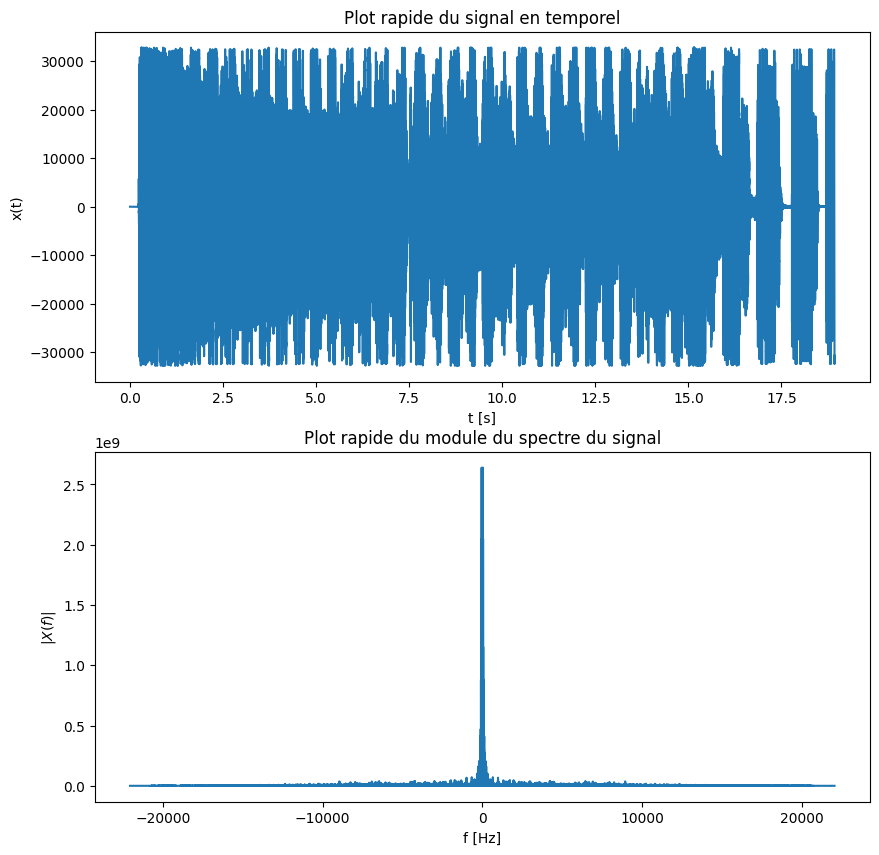

In [3]:
fech, x = read("data/sound.wav") # Music: https://www.purple-planet.com

print("Fréquence d'échantillonnage :", fech, "Hz")

def simple_plot(x,fech):
    """
    Permet de rapidement représenter le signal x en temporel, ainsi que le module de son spectre (en fréquentiel), avec les bons axes
    x : signal temporel, échantillonné à la fréquence fech
    fech : fréquence d'échantillonnage, en Hz
    """
    t = 1/fech*np.arange(0,len(x))
    
    # Calcul du spectre via la FFT et calcul des abscisses correspondantes, exprimées en fréquence f [Hz]
    X = np.fft.fftshift(np.fft.fft(x))
    f = fech/len(X)*np.arange(-np.ceil((len(X)-1)/2),np.floor((len(X)-1)/2)+1)
    
    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    plt.plot(t,x)
    plt.title("Plot rapide du signal en temporel")
    plt.xlabel("t [s]")
    plt.ylabel("x(t)")
  
    plt.subplot(2,1,2)
    plt.plot(f,np.abs(X))
    plt.title("Plot rapide du module du spectre du signal")
    plt.xlabel("f [Hz]")
    plt.ylabel("$|X(f)|$")
    plt.show()

simple_plot(x,fech)

## Conception du filtre

Il vous est maintenant demandé de compléter et commenter la fonction `audioFiltering(x,typeF,M,cutoff,fech)` qui conçoit et applique le filtre FIR sur le signal `x` en entrée. L'argument `x` est un vecteur (``numpy array``) de longueur $N$ et dont les entrées sont des valeurs réelles. Le support du signal `x` est donc $\{0,\dots,N-1\}$.
L'argument `typeF` est un string indiquant le type de filtre à concevoir. Il prend ses valeurs dans {'lowpass','highpass','bandpass'}.
L'argument `M` est un entier impair strictement positif correspondant à la longueur du filtre à concevoir (càd l'ordre du filtre + 1).
Finalement, l'argument `cutoff` est un scalaire ou un vecteur (`numpy array`) de longueur $2$. Il s'agit de la fréquence de coupure du filtre. Si le filtre est passe-bas ou passe-haut, cette fréquence est un scalaire. Si le filtre est passe-bande, il s'agit d'un vecteur.

La fonction doit renvoyer trois vecteurs (`numpy array`) : `xf`, `f` et `H` décrits ci-dessous (attention à bien retourner `(xf,f,H)`).

L'output `xf` est un vecteur (`numpy array`) de longueur $N$ contenant les valeurs du signal filtré. L'output `f` est un vecteur (`numpy array`) contenant les fréquences en Hz où est évaluée la réponse fréquentielle de votre filtre (pour la fréquence d'échantillonnage choisie). Finalement, l'output ``H`` est un vecteur (`numpy array`) de la même longueur que `f` contenant les valeurs possiblement complexes de la réponse fréquentielle, sur une période allant de $-\frac{f_{ech}}{2}$ à $\frac{f_{ech}}{2}$.

Pour concevoir ce filtre, certaines fonctions pourraient vous aider (utilisez-les) telles que `scipy.signal.firwin`, `scipy.signal.filtfilt` et  `scipy.signal.freqz` du package [SciPy](https://docs.scipy.org/) de Python. Vous pouvez facilement accéder au docstring de ces fonctions grâce à la commande `help(signal.firwin) par exemple`.

La fonction `scipy.signal.firwin` construit et renvoie donc les coefficients d'un filtre FIR, c'est-à-dire les coefficients $b_0,b_1,\dots,b_{M-1}$ tels que

$$h[n] = b_0\delta[n] + b_1\delta[n-1] + \dots + b_{M-1}\delta[n-(M-1)]$$

avec `M` le nombre de coefficients du filtre. Remarquez que la réponse impulsionnelle de ce filtre est exprimée ici en temps discret, vu que nous manipulons un signal continu qui a été échantillonné pour donner un signal discret et qui est filtré en temps discret. Toutefois, pour que `scipy.signal.firwin` travaille "comme si on était en temps continu", n'oubliez pas de lui spécifier la période d'échantillonnage (argument `fs`). Dans ce cas, l'argument `cutoff` représente la fréquence de coupure de votre filtre par rapport à `fs`. En outre, l'information du type de filtre à réaliser (passe-bas, passe-haut ou passe-bande) est à donner à l'argument `pass_zero`. Pour le reste, nous utiliserons les valeurs des paramètres par défaut (par exemple, Python utilise une fenêtre de type `Hamming` dans ce cas, qui est un peu plus élaborée qu'une fenêtre rectangulaire).

La fonction `scipy.signal.filtfilt` permet de filtrer le signal audio `x`. Vous pouvez utiliser les valeurs par défaut pour les différents paramètres, attention toutefois à bien spécifier ses arguments `b`, `a` et `x`. Le filtre que nous considérons ici n'a pas de coefficients au dénominateur (vu autrement, il possède un unique coefficient au dénominateur valant 1). Le signal filtré récupéré en sortie est noté `xf`.

La fonction `scipy.signal.freqz` permet de calculer la réponse fréquentielle d'un filtre sur base de ses coefficients. En effet, en plus de construire et appliquer le filtre FIR sur `x`, nous vous demandons aussi de calculer sa réponse fréquentielle sur $\left[\frac{-f_{ech}}{2},\frac{f_{ech}}{2}\right[$ (domaine des fréquences $f$ en Hz). Faîtes attention aux valeurs renvoyées par `scipy.signal.freqz`ainsi que le domaine de fréquences. En effet, il renverra le spectre sur $[0,f_{s}[$ si l'argument `fs` est spécifié (avec l'option `whole=True` que nous vous demandons d'utiliser, les autres paramètres étant ceux par défaut), il vous faudra donc modifier les valeurs de la réponse fréquentielle et modifier les abscisses `f` obtenues afin de correspondre à ce qui est demandé plus haut.
 
De ce fait, la dernière fonction qui pourrait vous être utile est `np.fft.fftshift`.

In [7]:
# LE CONTENU DE CETTE CELLULE EST A SOUMETTRE SUR INGINIOUS

def audioFiltering(filterName,x,typeF,M,cutoff,fech):
    """
    input:
        filterName: nom du filtre à utiliser ("butterworth", "chebyshevI", "chebyshevII")
        x: le signal à filtrer
        typeF: le type de filtre ("lowpass", "bandpass", "highpass")
        M: le nombre de coefficients du filtre
        cutoff: soit cutoff=x avec x la fréquence de coupure pour un lowpass et un highpass
                    cutoff=(a,b) utilisé pour le coupe-bande donc contient la valeur de départ et coupure
        fech: indique la fréquence d'échantillonnage 
    output:
        xf: signal filtré de x
        f: est un numpy array qui est de type [-fech/2; fech/2[ qui est le spectre des fréquences impulsionnelles
        H: réponse impulsionnelle. Contient un array avec les coefficients du filtre pour chaque fréquence
        name: nom du grpahe
    """       
    match filterName:
        case "Butterworth":
            window,a = signal.butter(M-1, cutoff, btype=typeF, fs=fech)
        case "ChebyshevI":
            window,a = signal.cheby1(M-1,3, cutoff, btype=typeF, fs=fech)
        case "ChebyshevII":
            window,a = signal.cheby2(M-1,3, cutoff, btype=typeF, fs=fech)
        case _:
            window = signal.firwin(M, cutoff, pass_zero=typeF, fs=fech) #coefficient du filtre
            a = 1
    
    xf = signal.filtfilt(window,a, x)
    
    f,H = signal.freqz(window,a, fs=fech,whole=True) #done les fréquences où on évalue et la réponse fréquentielle
    
    f=np.arange(-fech/2, fech/2, fech/len(H))
    H=np.fft.fftshift(H)
    
    return (xf,f,H)

Maintenant que vous avez sauvé la réponse fréquentielle du filtre, il vous est demandé de la représenter. Rappelez-vous que cette représentation fréquentielle peut être complexe. On ne pourrait donc pas juste la représenter telle quelle. Mais celle-ci peut alors être décrite comme $H(j\omega) = |H(j\omega)|e^{j\phi(H(j\omega))}$. On peut donc en extraire son module : $|H(j\omega)|$ ainsi que sa phase : $\phi(H(j\omega))$.

Sur base de cela, compléte(z) et commente(z) la fonction `plotFilter(f,H,name)` qui crée et sauvegarde une figure affichant le **module de la réponse fréquentielle** du filtre ainsi que la **phase de la réponse fréquentielle**, **sur l'axe des fréquences** $\left[\frac{-f_{ech}}{2},\frac{f_{ech}}{2}\right[$ en Hz.

Pour ce faire, utilisez la librairie [Matplotlib](https://matplotlib.org/index.html>). La fonction sauve également la figure au format png avec le nom `name` (la sauvegarde est déjà implémentée pour vous, ne supprimez pas ces lignes !). Faites attention à respecter la convention d'affichage d'un spectre continu, à annoter convenablement vos axes (labels, unités...), et à donner un titre.

In [8]:
# LE CONTENU DE CETTE CELLULE EST A SOUMETTRE SUR INGINIOUS


def plotFilter(f,H,name,bool_Ingi = True):
    """
    input:
        f: est un numpy array qui est de type [-fech/2; fech/2[ qui est le spectre des fréquences impulsionnelles
        H: réponse impulsionnelle. Contient un array avec les coefficients du filtre pour chaque fréquence
        name: nom du grpahe
    output:
        None
    """
    
    fig = plt.figure(figsize=(10,5))
    fig.tight_layout(pad=2.0)
    plt.subplot(211)
    
    print("Mon H max:", H.max())
    # A COMPLETER POUR AFFICHER LE MODULE DE LA REPONSE FREQUENTIELLE DU FILTRE
    plt.plot(f, abs(H))
    
    
    plt.subplot(212)
    
    plt.plot(f, np.angle(H))
    
    # A COMPLETER POUR AFFICHER LA PHASE DE LA REPONSE FREQUENTIELLE DU FILTRE
    
    # Pour permettre l'affichage dans le notebook et la sauvegarde sur Inginious (ne pas modifier !)
    if bool_Ingi:
        plt.savefig(name + '.png', bbox_inches='tight')
    else:
        plt.show()
    
    return

Maintenant, teste(z) les fonctions écrites en utilisant les cellules ci-dessous. 

### a) Test sur un signal simple

Avant d'appliquer la fonction `audioFiltering(x,typeF,M,cutoff,fech)` au signal `x` de *20 Cents*, vérifions que celle-ci réalise les opérations attendues. Pour cela, considérons un signal `y` donné par la somme entre une constante et un cosinus à la fréquence de 1000 Hz : 

$$ y(t) = 2+\cos(2\pi 1000 t)$$

et vérifions qu'après filtrage passe-bas, seule la composante DC du signal est récupérée. Au contraire, après filtrage passe-haut, seules les oscillations du cosinus doivent être récupérées. Le but est également d'observer les différences entre les différents filtres et types de filtres!

Nous choississons une fréquence d'échantillonnage de 20000 Hz (ce qui est largement suffisant pour respecter le théorème de Shannon).

**Signal y**


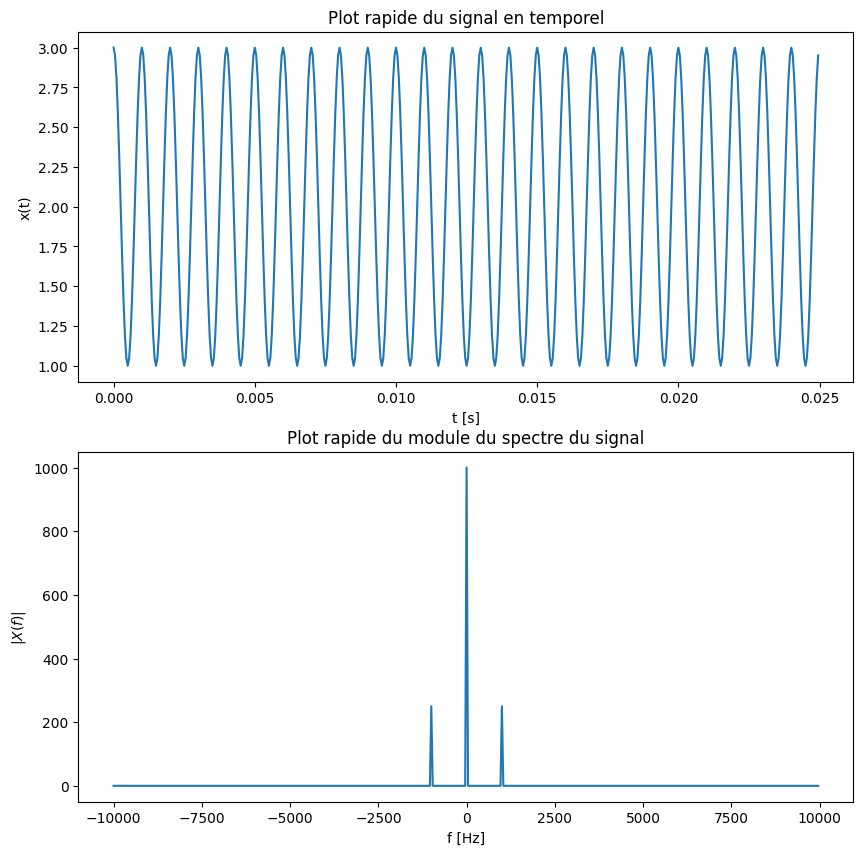

**Comparaison des 3 filtres en filtre passe-bas**
nom dufiltre Butterworth
x [3.         2.95105652 2.80901699 ... 2.58778525 2.80901699 2.95105652]
TypeF lowpass
M 3
cutoff 500
fech 20000
nom dufiltre ChebyshevI
x [3.         2.95105652 2.80901699 ... 2.58778525 2.80901699 2.95105652]
TypeF lowpass
M 3
cutoff 500
fech 20000
nom dufiltre ChebyshevII
x [3.         2.95105652 2.80901699 ... 2.58778525 2.80901699 2.95105652]
TypeF lowpass
M 3
cutoff 500
fech 20000


Text(0.5, 1.0, 'Module de la réponse fréquentielle du filtre ChebyshevII')

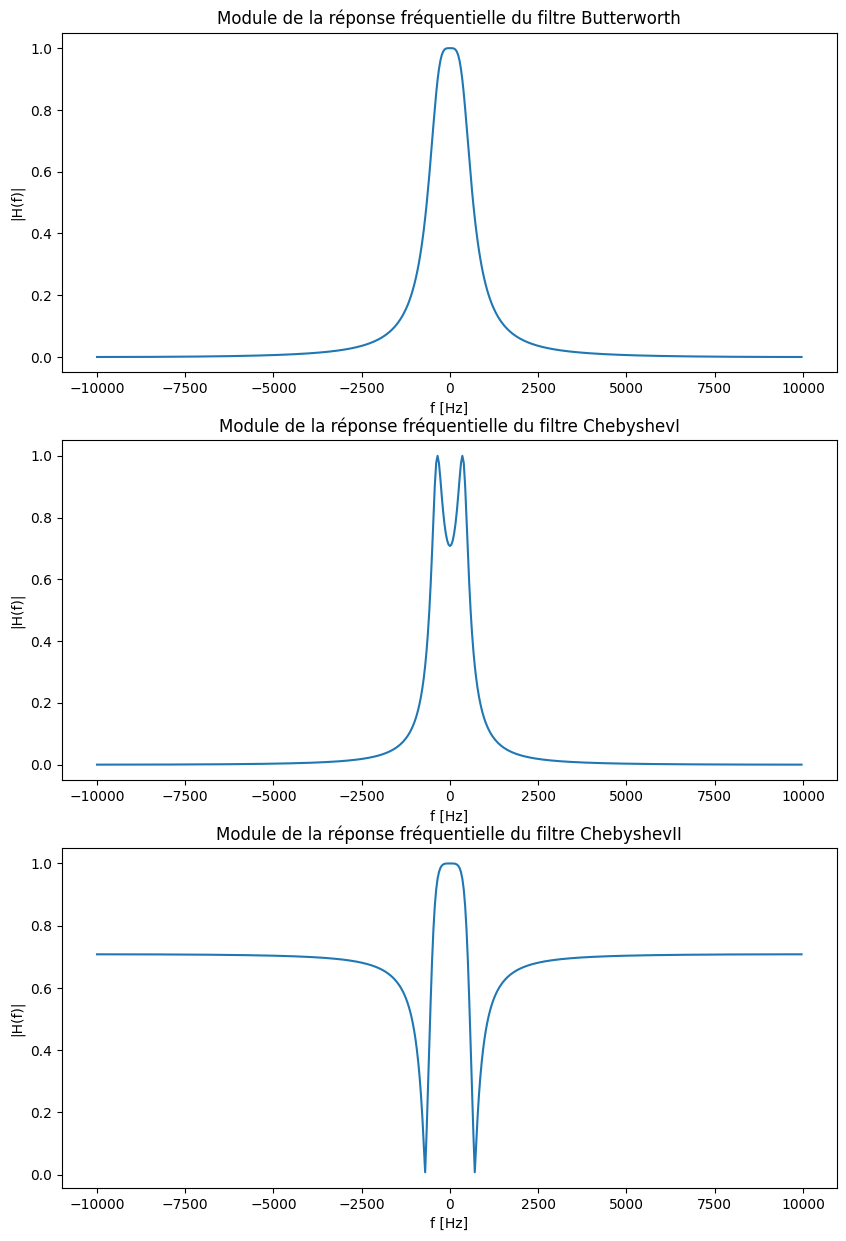

In [9]:
## CELLULE DE TEST

fech = 20000 # fréquence d'échantillonnage

t = np.arange(0,0.5,1/fech) # vecteur temps de 0 à 500 ms
y = 2 + np.cos(2*np.pi*1000*t)

print("**Signal y**")
simple_plot(y[0:int(len(y)/20)],fech) # troncature du signal, pour la lisibilité du plot

M=3 #N'hésitez pas à faire varier ce paramètre afin d'en observer les effets
typeF = 'lowpass' #N'hésitez pas à faire varier ce paramètre afin d'en observer les effets
freq_coupure = 500 # [2000,5000] si typeF == 'bandpass'

print("**Comparaison des 3 filtres en filtre passe-bas**")
(y_low_B,f_B,H_B) = audioFiltering("Butterworth",y,typeF,M,freq_coupure,fech)
(y_low_C1,f_C1,H_C1) = audioFiltering("ChebyshevI",y,typeF,M,freq_coupure,fech)
(y_low_C2,f_C2,H_C2) = audioFiltering("ChebyshevII",y,typeF,M,freq_coupure,fech)

plt.figure(figsize=(10,15))
plt.subplot(311)
plt.plot(f_B,np.abs(H_B))
plt.xlabel("f [Hz]")
plt.ylabel("|H(f)|")
plt.title("Module de la réponse fréquentielle du filtre Butterworth")
plt.subplot(312)
plt.plot(f_C1,np.abs(H_C1))
plt.xlabel("f [Hz]")
plt.ylabel("|H(f)|")
plt.title("Module de la réponse fréquentielle du filtre ChebyshevI")
plt.subplot(313)
plt.plot(f_C2,np.abs(H_C2))
plt.xlabel("f [Hz]")
plt.ylabel("|H(f)|")
plt.title("Module de la réponse fréquentielle du filtre ChebyshevII")

Signal de sortie pour les 3 filtres :
**Réponse à un filtre ButterworthChebyshevI et ChebyshevII**


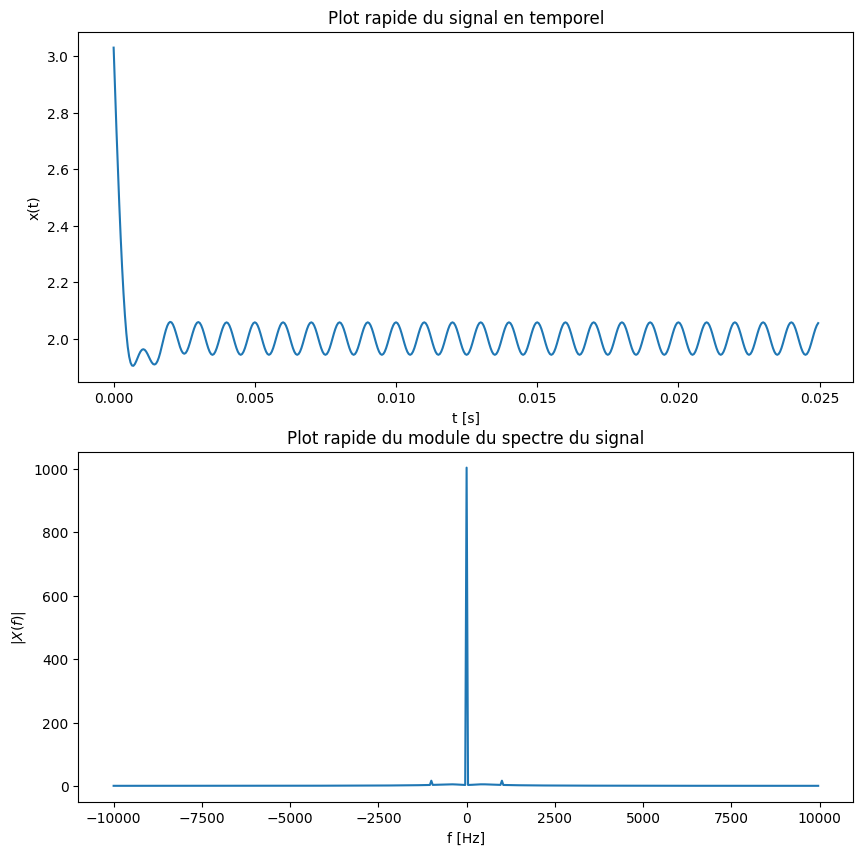

**Réponse à un filtre ChebyshevI**


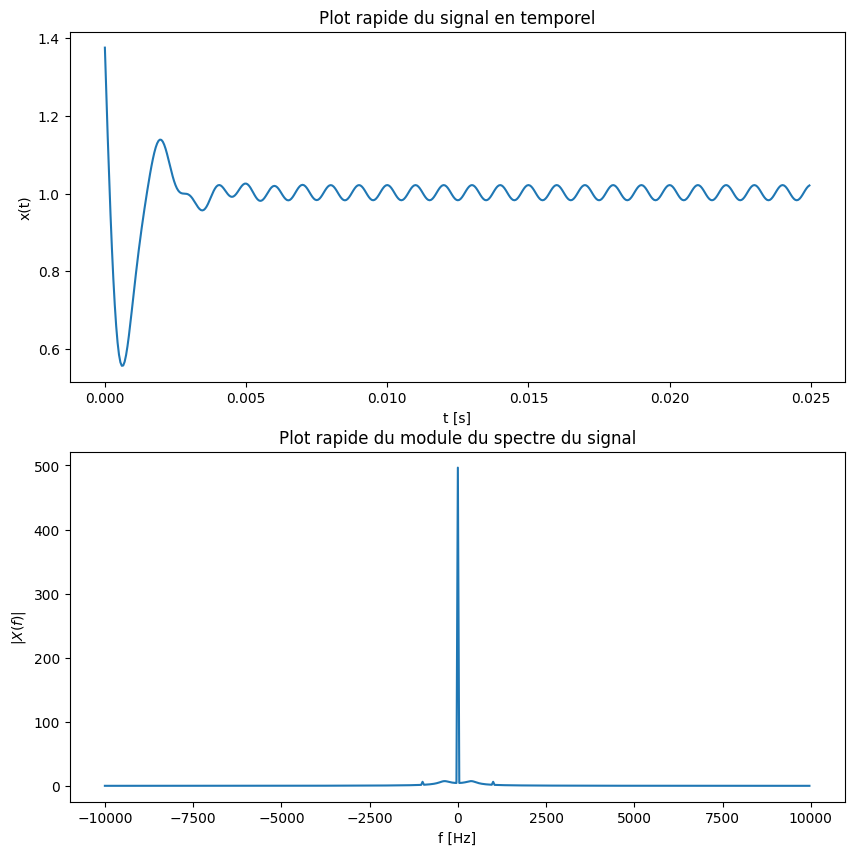

**Réponse à un filtre ChebyshevII**


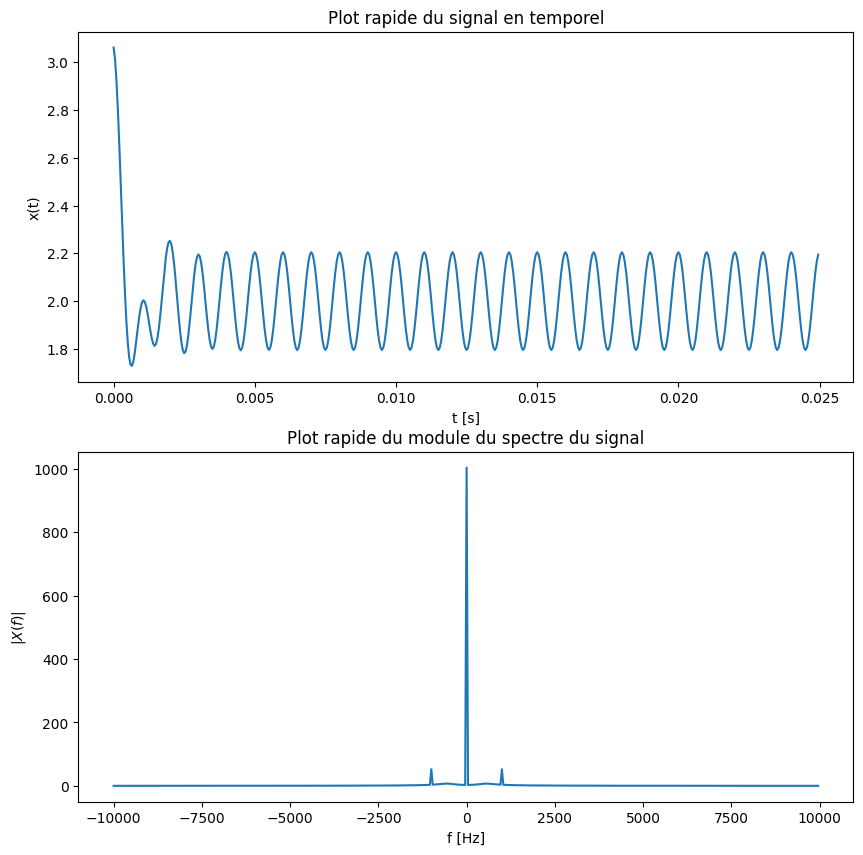

In [10]:
print("Signal de sortie pour les 3 filtres :")
print("**Réponse à un filtre ButterworthChebyshevI et ChebyshevII**")
simple_plot(y_low_B[0:int(len(y_low_B)/20)],fech)
print("**Réponse à un filtre ChebyshevI**")
simple_plot(y_low_C1[0:int(len(y_low_C1)/20)],fech)
print("**Réponse à un filtre ChebyshevII**")
simple_plot(y_low_C2[0:int(len(y_low_C2)/20)],fech)

Réponse fréquentielle du filtre Butterworth :
Mon H max: (0.9999999999999996+0j)


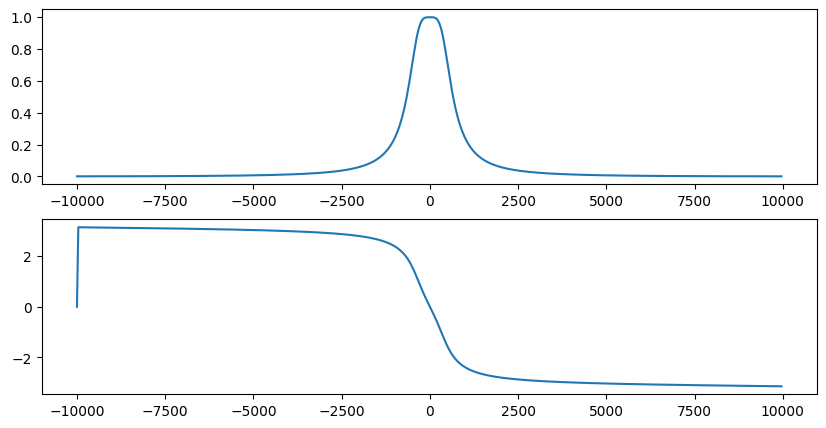

In [11]:
# N'hésitez pas à tester votre code de représentation en executant cette cellule avec différents arguments !
print("Réponse fréquentielle du filtre Butterworth :")
plotFilter(f_B,H_B,"test_butterworth",False)

Si votre code fonctionne correctement, vous devriez obtenir un signal $y_{low}(t)$ correspondant uniquement à la composante DC de $y(t)$, et qui vaut donc 2 pour tous les $t$. Notez qu'il est normal d'observer un léger délai au début avant d'obtenir effectivement $2$ pour tous les $t$, à cause de la réponse impulsionnelle finie du filtre. Par ailleurs, dans le cas du filtrage passe-haut, vous devez obtenir un signal $y_{high}(t)=\cos(2\pi 1000 t)$, après un petit délai. Observez les spectres obtenus. Correspondent-ils à vos attentes ? Observez également les propriétés de symétrie conjuguée des spectres obtenus.

### b) Application du filtre au signal de *20 Cents*
Si votre filtre a l'air de se comporter comme attendu, vous pouvez maintenant l'appliquer au signal audio de *20 Cents*. Commençons par recharger en mémoire ce signal (au cas où vous auriez redéfini une variable `x` dans votre implémentation) et le représenter, afin de plus facilement observer les effets du filtrage.

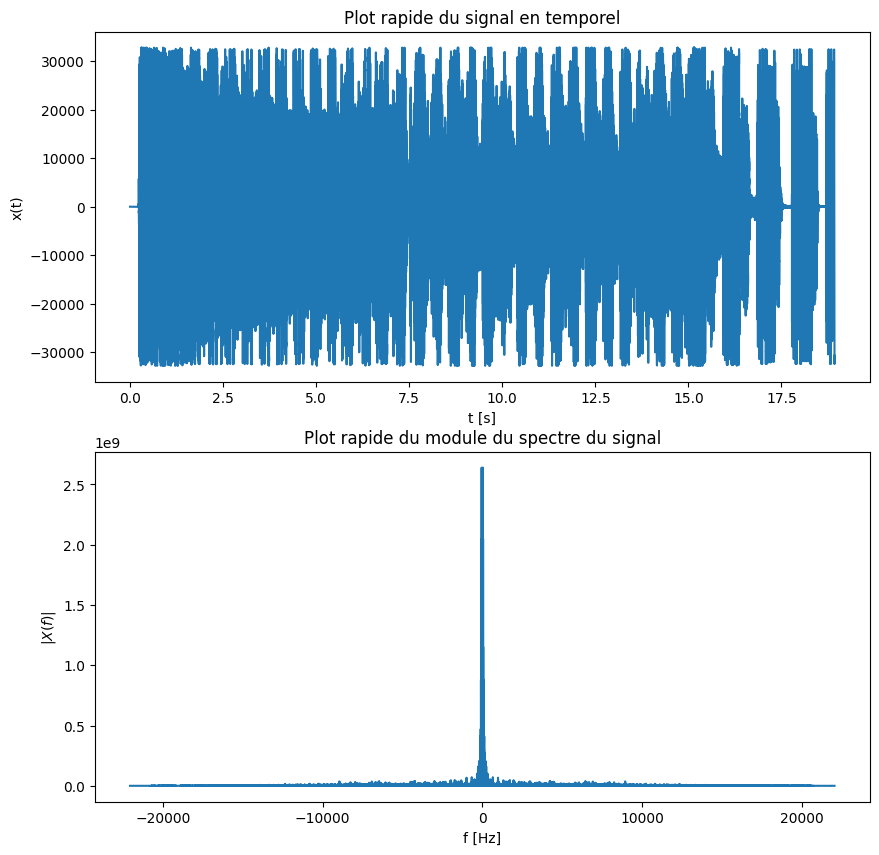

In [12]:
fech, x = read("data/sound.wav") # On recharge en mémoire le signal de 20 Cents (au cas où il aurait été modifié...)

simple_plot(x,fech)

Appliquons et affichons maintenant les différents filtres :

nom dufiltre Butterworth
x [     0      0      0 ... -30791 -30730 -30659]
TypeF lowpass
M 3
cutoff 2000
fech 44100
Réponse fréquentielle du filtre passe-bas :
Mon H max: (1.0000000000000007+0j)


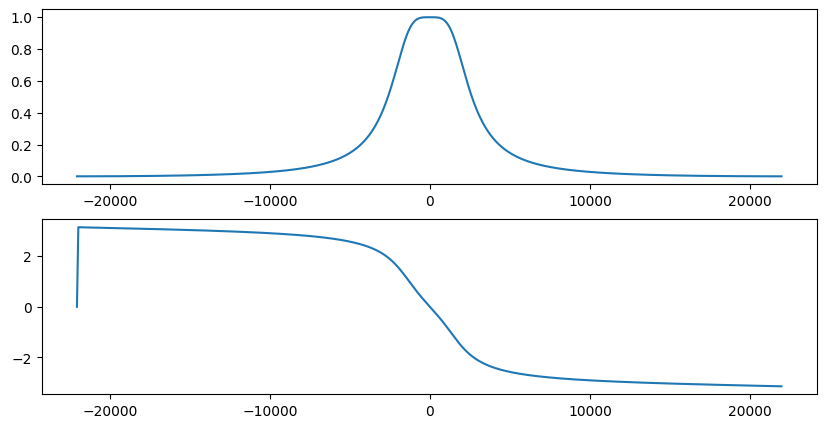

Signal de sortie :


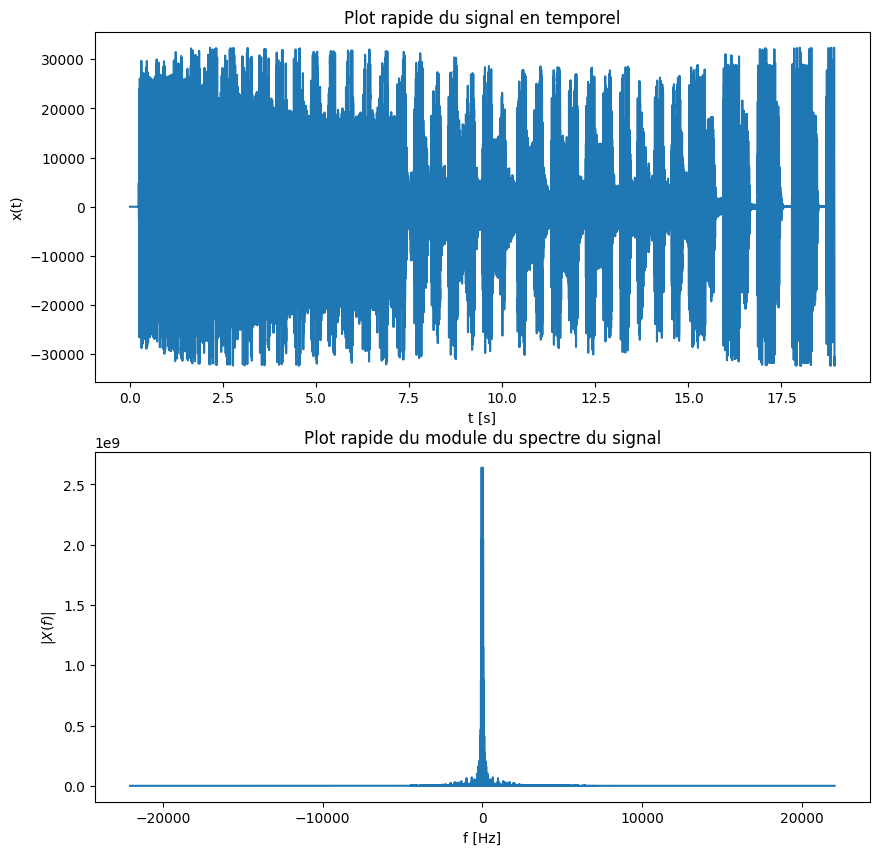

In [13]:
## CELLULE DE TEST - filtre Butterworth filtrage passe-bas

# On applique un filtre passe-bas pour tuer les fréquences supérieures à 2 kHz
(x,f,H) = audioFiltering('Butterworth',x,'lowpass',3,2000,fech)

print("Réponse fréquentielle du filtre passe-bas :")
plotFilter(f,H,"test",False)
print("Signal de sortie :")
simple_plot(x,fech)

# Enregistrement du son pour vous permettre d'écouter les effets du filtrage passe-bas
write("passe_bas.wav",fech,np.asarray(x, dtype=np.int16)) 

# N'hésitez pas à tester les deux autres filtre dont on s'occupe dans ce devoir afin d'entendre leurs effets !*
# On peut aussi tester d'applique un filtre passe-haut pour tuer les fréquences inférieures à 5 kHz par exemple en changeant
# 'lowpass' en 'highpass', le 2000 en 5000 et en changeant le nom du fichier sur lequel il va s'enregistrer.
# On peut faire de même pour tester un filtre passe-bande pour récupérer seulement les fréquences entre 2000 et 5000 Hz 
# en remplaçant 'lowpass' par 'bandpass', le 2000 en [2000,5000] et le nom du fichier sur lequel il va s'enregistrer.

Si tout s'est déroulé correctement, vous pouvez maintenant écouter le son de *20 Cents* filtré dans les fichiers `sortie.wav` ainsi obtenus à l'aide de votre lecteur préféré. En outre, observez les spectres affichés ci-dessus. Correspondent-ils à vos attentes pour un filtrage passe-bas, passe-haut ou passe-bande, avec les fréquences de coupure spécifiées ? Observez également les propriétés de symétrie conjuguée des spectres obtenus.